# Imports

In [164]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

# Helper Functions

In [148]:
def create_trip_duration_column(df):
    # trip duration
    df["trip_duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    # convert trip_duration to minutes
    df["trip_duration"] = df["trip_duration"].apply(lambda x: x.total_seconds()/60)

    return df

def create_pickup_plus_dropoff_id(df):
    df["PU_DO_ID"] = df["PULocationID"].astype(str) + "_" + df["DOLocationID"].astype(str)

    return df

def filter_duration(df):
    df = df[(df.trip_duration >= 1) & (df.trip_duration <= 60)]

    return df

# Load Data

In [149]:
df_train = pd.read_parquet("data/green_tripdata_2021-01.parquet")
df_val = pd.read_parquet("data/green_tripdata_2021-02.parquet")

# Feature Engineering

In [150]:
df_train = create_trip_duration_column(df_train)
df_val = create_trip_duration_column(df_val)

df_train = create_pickup_plus_dropoff_id(df_train)
df_val = create_pickup_plus_dropoff_id(df_val)

# Univariate Analysis

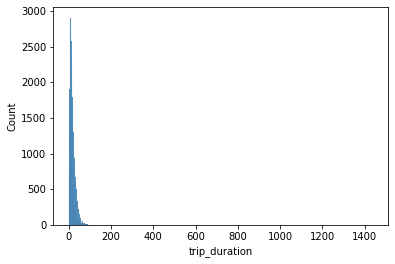

In [152]:
# distribution of trip_duration
sns.histplot(df_train, x = "trip_duration");

In [153]:
df_train.trip_duration.describe()

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
25%          8.000000
50%         13.883333
75%         23.000000
max       1439.600000
Name: trip_duration, dtype: float64

In [154]:
# due to some strange trip durations and to filter some data, lets filter based on trip_duration
df_train = filter_duration(df_train)
df_val = filter_duration(df_val)

# Select Features

In [155]:
# select only some features for the example
categorical_features = ["PU_DO_ID"]
numerical_features = ["trip_distance"]

# Prep Features

In [156]:
# tranform the categorical features with one hot encoding
# first we transform the categorial features in str type
df_train[categorical_features] = df_train[categorical_features].astype(str)
# then we transform the df into a matrix using DictVectorizer, 
# which does the OHE with cat features
train_dicts = df_train[categorical_features + numerical_features].to_dict(orient="records")
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical_features + numerical_features].to_dict(orient="records")
X_val = dv.transform(val_dicts)

In [157]:
y_train = df_train.trip_duration.values
y_val = df_val.trip_duration.values

# Train Model

## Linear Regression

In [158]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)

/home/olini/Projects/mlops-zoomcamp/mlops-zoomcamp/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/olini/Projects/mlops-zoomcamp/mlops-zoomcamp/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


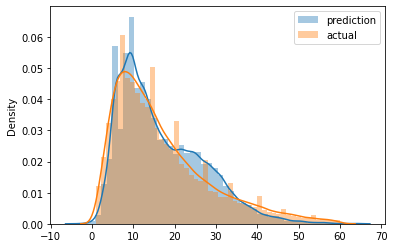

In [159]:
sns.distplot(y_pred, label = "prediction")
sns.distplot(y_train, label = "actual")

plt.legend()

In [160]:
print(f"Training RMSE: {mean_squared_error(y_train, y_pred, squared = False)}")

Training RMSE: 5.699564118202546


In [161]:
y_pred_val = lr.predict(X_val)
print(f"Validation RMSE: {mean_squared_error(y_val, y_pred_val, squared = False)}")

Validation RMSE: 7.758715199477344


## Lasso Regression

In [162]:
lasso = Lasso()
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_train)

print(f"Training RMSE: {mean_squared_error(y_train, y_pred, squared = False)}")

y_pred_val = lasso.predict(X_val)
print(f"Validation RMSE: {mean_squared_error(y_val, y_pred_val, squared = False)}")

Training RMSE: 11.562050466293025
Validation RMSE: 12.212583224318818


## Ridge Regression

In [163]:
ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_train)

print(f"Training RMSE: {mean_squared_error(y_train, y_pred, squared = False)}")

y_pred_val = ridge.predict(X_val)
print(f"Validation RMSE: {mean_squared_error(y_val, y_pred_val, squared = False)}")

Training RMSE: 10.712682923244786
Validation RMSE: 11.34260394325033


## Save best model

In [166]:
with open("models/lin_reg.bin", "wb") as file:
    pickle.dump((dv, lr), file)